https://github.com/benjs/DCTransformer-PyTorch

http://www.bretl.com/mpeghtml/DCxfrm.HTM

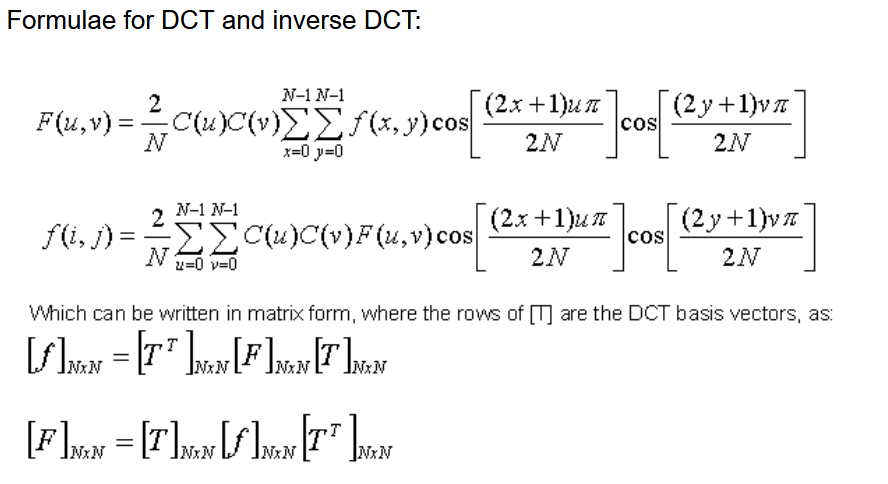


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

rgb_to_ycbcr = torch.tensor([
    [ 0.299000,  0.587000,  0.114000],
    [-0.168736, -0.331264,  0.500000],
    [ 0.500000, -0.418688, -0.081312]
])

rgb_to_ycbcr_bias = torch.tensor([0, 0.5, 0.5])

class RGBToYCbCr(nn.Module):
    """Converts a tensor from RGB to YCbCr color space.
    Using transform from https://github.com/libjpeg-turbo/libjpeg-turbo/blob/master/jccolor.c
    """
    def __init__(self):
        super().__init__()
        
        self.register_buffer('transform', rgb_to_ycbcr[:, :, None, None], persistent=False)
        self.register_buffer('transform_bias', rgb_to_ycbcr_bias, persistent=False)

    @torch.no_grad()
    def forward(self, x:torch.Tensor):
        return F.conv2d(x, self.transform, self.transform_bias)

# Base matrix for luma quantization
T_luma = torch.tensor([
    [16, 11, 10, 16,  24,  40,  51,  61],
    [12, 12, 14, 19,  26,  58,  60,  55],
    [14, 13, 16, 24,  40,  57,  69,  56],
    [14, 17, 22, 29,  51,  87,  80,  62],
    [18, 22, 37, 56,  68, 109, 103,  77],
    [24, 35, 55, 64,  81, 104, 113,  92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103,  99]
        ])

# Chroma quantization matrix
Q_chroma = torch.tensor([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

# Base matrix for luma quantization
T_luma = torch.tensor([
    [16, 11, 10, 16],
    [12, 12, 14, 19],
    [14, 13, 16, 24],
    [14, 17, 22, 29]
        ])

# Chroma quantization matrix
Q_chroma = torch.tensor([
    [17, 18, 24, 47],
    [18, 21, 26, 66],
    [24, 26, 56, 99],
    [47, 66, 99, 99]
])

def Q_luma(q:float) -> torch.Tensor:
    """Generate the luma quantization matrix

    Args:
        q (float): Quality parameter (1-100)
    """
    s = 5000./q if q < 50 else 200 - 2*q
    return torch.floor((s*T_luma + 50)/100)

def zigzag(n:int) -> torch.Tensor:
    """Generates a zigzag position encoding tensor. 
    Source: https://stackoverflow.com/questions/15201395/zig-zag-scan-an-n-x-n-array
    """

    pattern = torch.zeros(n, n)
    triangle = lambda x: (x*(x+1))/2

    # even index sums
    for y in range(0, n):
        for x in range(y%2, n-y, 2):
            pattern[y, x] = triangle(x + y + 1) - x - 1

    # odd index sums
    for y in range(0, n):
        for x in range((y+1)%2, n-y, 2):
            pattern[y, x] = triangle(x + y + 1) - y - 1

    # bottom right triangle
    for y in range(n-1, -1, -1):
        for x in range(n-1, -1+(n-y), -1):
            pattern[y, x] = n*n-1 - pattern[n-y-1, n-x-1]

    return pattern.t().contiguous()

class DCTCompression(nn.Module):
    def __init__(self, N=8, q=50):
        super().__init__()

        self.N = N        
        
        # Create all N² frequency squares
        # The DCT's result is a linear combination of those squares.
        
        # us:
        # [[0, 1, 2, ...],
        #  [0, 1, 2, ...],
        #  [0, 1, 2, ...],
        #  ... ])
        us = torch.arange(N).repeat(N, 1)/N # N×N
        vs = us.t().contiguous() # N×N
        
        xy = torch.arange(N,dtype=torch.float) # N

        # freqs: (2x + 1)uπ/(2B) or (2y + 1)vπ/(2B)
        freqs = ((xy + 0.5)*3.1415)[:, None, None] # N×1×1

        # cosine values, these are const no matter the image.
        cus = torch.cos(us * freqs) # N×N×N
        cvs = torch.cos(vs * freqs) # N×N×N

        # calculate the 64 (if N=8) frequency squares
        freq_sqs = cus.repeat(N, 1, 1, 1) * cvs[:, None] # N×N × N×N
        
        # Put freq squares in format N²×1×N×N (same as kernel size of convolution)
        # Use plt.imshow(torchvision.utils.make_grid(BlockDCT.weight, nrow = BlockDCT.N)) to visualize
        self.register_buffer('weight', freq_sqs.view(N*N, 1, N, N))

        zigzag_vector = zigzag(self.N).view(self.N**2).to(torch.long) # N²
        self.register_buffer('zigzag_weight', F.one_hot(zigzag_vector).to(torch.float).inverse()[:,:,None,None])

        # matrix with sqrt(2)/2 at u=y=0
        norm_matrix = torch.ones(N, N)
        print(norm_matrix.size())
        norm_matrix[:,0] = torch.sqrt(torch.tensor(2.)).repeat(N)/2
        norm_matrix[0,:] = norm_matrix[:,0]
        norm_matrix *= (2/N)

        norm_weight = norm_matrix.view(N*N,1).repeat(1,N*N)*torch.eye(N*N) # N²×N²
        self.register_buffer('norm_weight', norm_weight[:,:,None,None])

        quant_vals = 1/torch.cat((Q_luma(q).view(N*N), Q_chroma.view(N*N), Q_chroma.view(N*N)), dim=0)
        quant_weight = quant_vals.repeat(3*N*N,1)*torch.eye(3*N*N)
        self.register_buffer('quant_weight', quant_weight[:,:,None,None])

    @torch.no_grad()
    def forward(self, x:torch.Tensor):
        B, C, H, W = x.size()
        assert H % self.N == 0 or W % self.N == 0, "Images size must be multiple of N (TBD)"

        out = x.view(-1, 1, H, W) # Increase batch size by channels, reduce channels to 1
        out = F.conv2d(out, weight=self.weight, stride=self.N)
        out = F.conv2d(out, self.norm_weight)
        out = F.conv2d(out, self.zigzag_weight)
        out = out.view(B, C*self.N*self.N, H//self.N, W//self.N)
        out = F.conv2d(out, self.quant_weight)
        return out



In [47]:
# from dctransformer.transforms import DCTCompression

In [48]:
n_size = 4
dct = DCTCompression(N=n_size)

torch.Size([4, 4])


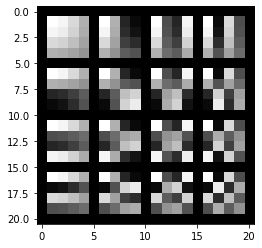

In [49]:
import matplotlib.pyplot as plt
import torch
import torchvision

weights = (dct.weight+1)/2 # from (-1,1) to (0,1)
im_grid = torchvision.utils.make_grid(weights, nrow=n_size, padding=1)
plt.imshow(im_grid.permute(1,2,0))
plt.show()

In [50]:
im_grid.permute(1,2,0).size()

torch.Size([21, 21, 3])

In [51]:
weights.size()

torch.Size([16, 1, 4, 4])

Why (weights[1] + weights[8])/2

In [52]:
# DCT transform should yield high values at position 1 and 2 
# (not 1 and 8 because of zigzag ordering)
img = (weights[1] + weights[8])/2
img = (img+1)/2 * 255

In [53]:
img

tensor([[[255.0000, 232.8979, 191.2521, 173.9991],
         [208.5025, 191.2525, 161.8037, 159.3739],
         [191.2479, 179.0504, 159.3735, 161.7982],
         [232.8956, 223.1240, 203.4469, 191.2487]]])

In [54]:
img3 = img.unsqueeze(0).repeat(1,3,1,1) # Need batched and 3 channels
img3 = (img3+1)/2 * 255
torch.round(dct(img3)).view((n_size ** 2) * 3)

tensor([ 5.1440e+03,  2.6000e+02, -4.3300e+02,  1.9450e+03,  3.1700e+02,
         1.9950e+03,  9.0100e+02, -8.0000e+01,  1.8200e+02,  9.7100e+02,
         1.1400e+02,  4.8200e+02, -1.5000e+01,  4.2000e+02,  2.3200e+02,
         1.0300e+02,  4.8410e+03,  1.5900e+02, -1.8000e+02,  6.6200e+02,
         2.1100e+02,  1.1400e+03,  4.8500e+02, -2.3000e+01,  1.0600e+02,
         4.8500e+02,  3.3000e+01,  1.1700e+02, -4.0000e+00,  1.0800e+02,
         5.2000e+01,  3.0000e+01,  4.8410e+03,  1.5900e+02, -1.8000e+02,
         6.6200e+02,  2.1100e+02,  1.1400e+03,  4.8500e+02, -2.3000e+01,
         1.0600e+02,  4.8500e+02,  3.3000e+01,  1.1700e+02, -4.0000e+00,
         1.0800e+02,  5.2000e+01,  3.0000e+01])